# Dataset
I am using the "Quark and Gluon Jets" dataset from EnergyFlow [[https://energyflow.network/docs/datasets/#quark-and-gluon-jets]] for the initial part of my project[^1]. I will use this data at two different stages of my project:

**Stage 1 - Hypothesis Testing**

In this phase, I will:
  - Peform **statistical hypothesis tests** ($\chi^{2}$, Likelihood Ratio tests) to verify **quark vs. gluon distributions**.
  - Use features like **multiplicity & jet spread** to check how different quark and gluon jets are.
  - Apply **classification techniques** to separate quark vs. gluon jets.
The goal at this stage is to develop a **baseline statistical understanding** of how quarks vs. gluon jets differ.

**Stage 2 - Bayesian Uncertainty Quantififation**

After completing hypothesis testing, I will:
  - Train a **Neural Network (NN)** to classify quark vs. gluon jets.
  - Modify the NN into a **Bayesian Neural Network (BNN)** to ***quantify*** uncertainty.
  - Test if **Uncertainty Quantification (UQ)** helps improve **classification accuracy** (e.g., are some jets “hard to classify” due to overlapping properties?).


The dataset "Quark and Gluon Jets" focuses only on jet types (*quarks vs. gluon*), not full event-classification. It does not include a wide range of event types (like Higgs decays). So, for UQ, I will switch to "CMS Open Data and the MOD HDF5 Format", again from EnergyFlow [[https://energyflow.network/docs/datasets/#cms-open-data-and-the-mod-hdf5-format]]. 

Why use different dataset later?
- It represents real detector data, where uncertainties arise naturally.
- It allows us to test if ML models trained on simulated jets generalize to real physics data.
- This is crucial for practical applications in experimental physics.

Let's begin by understanding and visualising the dataset.

[^1]: The dataset is a ".npz" file, which is a **compressed NumPy archive**. It stores multiple NumPy arrays inside one file. We have to manually extract arrays before using them (unlike ".csv" - which stores tabular data and can be loaded into Pandas with df.head()).

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define file path (using the first file for exploration)
file_path = "/Users/sauravbania/My Projects/Uncertainty-Quantification-CMS/datasets/QG_jets_withbc_0.npz"

# Loading the dataset
data1 = np.load(file_path)

# Checking what arrays are stored in this file
print("Dataset Keys:", data1.files)

# Inspecting the shape of each array
for key in data1.files:
    print(f"{key}: shape {data1[key].shape}")

#Extracting first 5 jets from the X array
X_val = data1["X"]
y_val = data1["y"]

#for i in range(2):
    #print(f"Jet {i}:")
    #print(X_val[i])  # Print the particle features for each jet
    #print(y_val[i])
    #print(f"Label: {'Quark' if y_val[i] == 1 else 'Gluon'}\n")  # Convert label to text

Dataset Keys: ['X', 'y']
X: shape (100000, 134, 4)
y: shape (100000,)


This is telling us that the dataset has two arrays X:(100000,134,4) and y(100000). There are **100000 Quark and Gluon Jets** stored in this file. Each jet consists of a maximum of **134 particles** (multiplicity varies from jet to jet) and has **4 features**. The y array tells us the label for Quarks and Gluons: y == 1 for Quarks and y == 0 for Gluons, as you can clearly see in the output.

As mentioned, the maximum number of multiplicity is 134, so the jets have been padded with zero-particles. I will first like to see how many non-zero particles we have per jet. I just need to check $p_{T}$ i.e., the first feature for each jet for non-zero values. 


100000
134
4
 pT: 0.986502732089,
 rapidity: -1.35386410457, 
 azimuthal angle: 0.26445848313, 
 pdgid: 22.0
Length of multiplicity list: 100000
First 5 jet multiplicities: [44, 41, 38, 52, 45]
Length of gluon multiplicity list: 50000
Length of quark multiplicity list: 50000


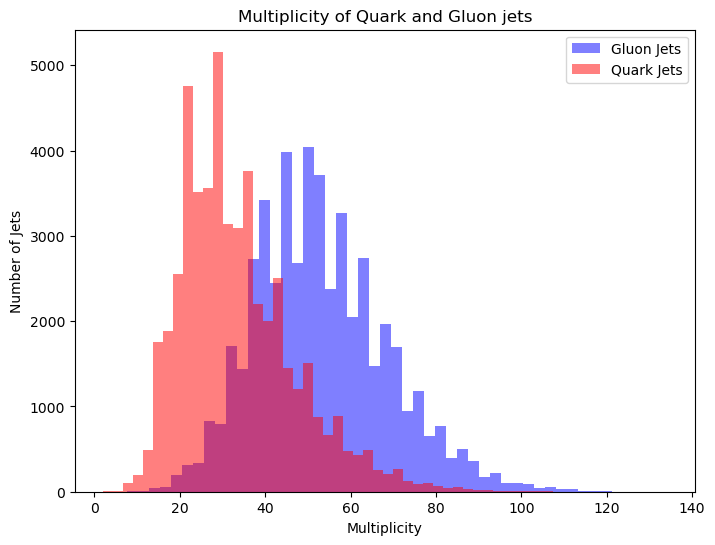

In [8]:
print(len(X_val))
print(len(X_val[0]))
print(len(X_val[0,0]))

print(f" pT: {X_val[0,0,0]},\n rapidity: {X_val[0,0,1]}, \n azimuthal angle: {X_val[0,0,2]}, \n pdgid: {X_val[0,0,3]}") # X_val[0,0,0] = [first jet, first particle in jet, first feature of that particle]

counter = []
for i in range(len(X_val)): # for i in 100000 jets 
    counter.append(np.sum(X_val[i, :, 0] > 0)) # X_val[i, :, 0] = For each jet checking the pT values to be > 0.

print(f"Length of multiplicity list: {len(counter)}")
# print(counter)
print(f"First 5 jet multiplicities: {counter[:5]}")

g_mul = [] # Gluon multiplicity list
q_mul = [] # Quark multiplicity list
for i in range(len(y_val)):
    # print(f"{counter[i]}, {y_val[i]}")
    if y_val[i] == 0.0:
        g_mul.append(counter[i])
        #print(f"Multiplicity of gluon jets:{counter[i]}, {y_val[i]}")
    else:
        q_mul.append(counter[i])

print(f"Length of gluon multiplicity list: {len(g_mul)}")
print(f"Length of quark multiplicity list: {len(q_mul)}")
# Here youprint(q_mul)

plt.figure(figsize=(8, 6))
plt.hist(g_mul, bins=50, alpha=0.5, label="Gluon Jets", color="blue")
plt.hist(q_mul, bins=50, alpha=0.5, label="Quark Jets", color="red")
plt.xlabel('Multiplicity')
plt.ylabel('Number of Jets')
plt.title("Multiplicity of Quark and Gluon jets")
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.hist(X_val[0,0,0], bins=50, alpha=0.5, label="Transverse Momentum", color="blue")
# plt.xlabel('Transverse monentum')
# plt.ylabel('y')
# plt.legend()
# plt.show()


We can see from the plot that the multiplicity of gluon jets is higher than the quark jets, as expected, as quark jets should have fewer particles than gluon jets. The taller bars mean more jets fall in that multiplicity range.

Now, let's understand more about the features and how we can visualize them. 

**Transverse Monentum**

At CMS (LHC), high-energy collisions happen along the beamline. So, the transverse momentum ***$p_{T}$*** tells us how much momentum is carried perpendicular to the beamline. 
From the histogram above, we can see that the Quark jets have fewer particles per jet vs. the Gluon jets. Physics tells us that quark jets tend to have higher $p_{T}$ in fewer particles, and gluon jets tend to distribute $p_{T}$ more broadly across many particles. 

For visualization, we can plot:
- **Jet $p_{T}$ distribution:** To Compare Quark vs. Gluon jets.
- **Mean $p_{T}$ per jet:** To verify if Quarks have higher-energy leading particles. 

**Rapidty $(y)$**

In particle physics, rapidity $(\eta)$ is a measure of how fast a particle moves along the beam axis (z-direction) in a collider experiment like the CMS detector at the LHC.

It is closely related to velocity and energy and is preferred over velocity in high-energy experiments because:
- It is additive under Lorentz transformations (useful for comparing particles moving at different speeds).
- It remains well-behaved even at ultra-relativistic speeds (where velocity approaches the speed of light c).

Formula for Rapidity:
$y = \frac{1}{2}ln\frac{E + p_{z}}{E - p_{z}}$

where:
- $E =$ **Total energy** of the particle
- $p_{Z} =$ **Momentum along the beam (z-axis)**

Since total energy E is difficult to measure for each particle, we often use pseudorapidity $(\eta)$ instead.

**Pseudorapidity $(\eta)$**

Since rapidity $(y)$ requires knowing energy $(E)$, which is not always easy to measure, we use pseudorapidity $(\eta)$, which depends only on the angle of the particle’s trajectory. 

Defined as:

$\eta = -ln \tan\frac{\theta}{2}$, where $\theta$ is the **Polar angle** (angle from the beam axis).

Pseudorapidity describes how **forward or backward** a particle is relative to the beamline.
- $\eta = 0$ → Particle moves perpendicular to the beam.
- $\eta > 0$ → Particle moves forward along the beam.
- $\eta < 0$ → Particle moves backward along the beam.



***Why use pseudorapidity $(\eta)$?***
- It is easier to measure in a detector (depends only on $\theta$).
- At high energies, $y \approx \eta$, so they are almost the same.
- It is **Lorentz invariant** - *remains the same under boosts along the beamline*.

***Why is Pseudorapidity $(\eta)$ important in Jet Physics?***
- Jets from quarks and gluons are spread in pseudorapidity $(\eta)$.
- Different jet types (quark jets vs. gluon jets) have different $\eta$ distributions.
- Central jets $(\eta \approx 0)$ behave differently from forward jets $(\eta > 2)$.
- Studying rapidity helps in jet tagging, background rejection, and event classification.


Similarly here, we can plot:
- **$\eta$ distribution:** To compare quark vs. gluon jets.
- **2D histogram of $(\eta, p_T)$:** To check how transverse momentum varies with rapidity.


**Azimuthal Angle $\phi$**

It represents the angle of the particle in transverse place. It tells us about the spread of the jet. 

So, we can plot:
- **Jet $\phi$ distribution:** To check if quark/gluon jets have uniform spread.
- **$(\eta, \phi)$ scatter plot:** To visualize jet spread in the detector.

| Feature | Plot Type | Goal |
| ----------- | ----------- | ----------- |
| Jet $p_{T}$ distribution | Histogram | Compare quark vs. gluon jets' energy |
| Mean $p_{T}$ per jet | Bar Plot / Box Plot | Check if quarks have higher-energy leading particles |
| Rapidity $\eta$ distribution | Histogram | Compare quark vs. gluon jets' forward/backward spread |
| 2D histogram of $(\eta, p_{T})$ | 2D Heatmap | Show how transverse momentum varies with rapidity |
| Jet $\phi$ distribution | Histogram | Check if quark/gluon jets have uniform angular spread |
| $(\eta, \phi)$ scatter plot | Scatter plot | Visualize jet structure in detector space |


[4.34396513e+00 2.60121413e+00 2.43598450e-02 ... 8.70818191e+01
 1.00271019e+02 1.14074300e+02]


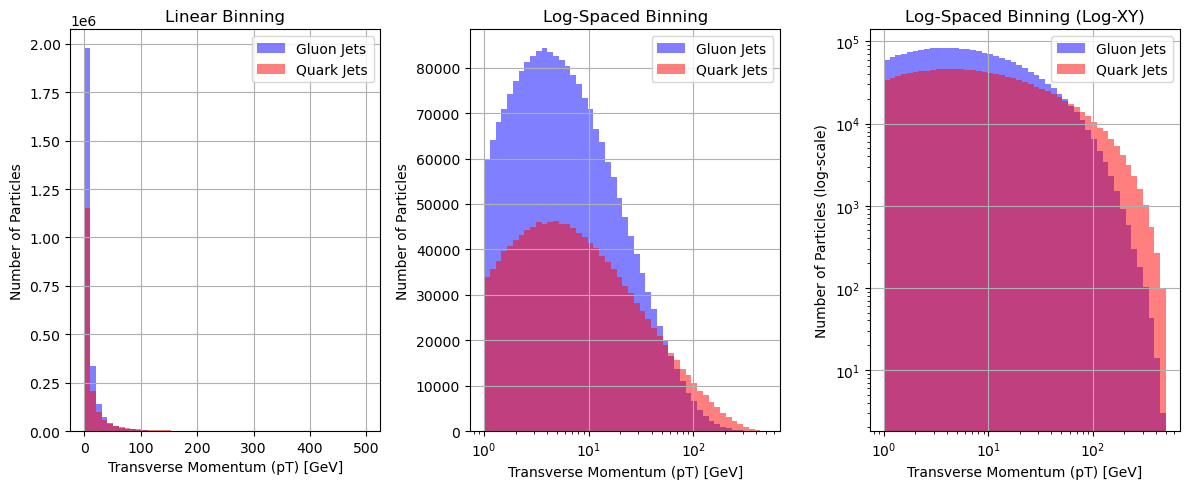

In [9]:
# Transverse Momentum Plots

pT_val = X_val[:,:,0] # Storing all pT values

# The zero-padded values are still there and if we separate now then start plotting then the -
# - zeroes in the dataset will artificially pull the - 
# - distribution toward 0, which is not physically meaningful -
# - since those values are just placeholders for missing particles.

# Separating pT values for wuarks and gluons based on label y
pT_quark = []
pT_gluon = []
for i in range(len(y_val)):
    if y_val[i] == 1:
        pT_quark.append(X_val[i, X_val[i,:,0] > 0, 0]) # X_val[i, X_val[i,:,0] > 0, 0] = X_val[ith jet, pT>0 of all in ith jet, first term]
    if y_val[i] == 0:
        pT_gluon.append(X_val[i, X_val[i,:,0] > 0, 0])

# print(f" Transverse Momentum of all particles: {pT_val}")
# print(f"First 5 quark jet pT values: {pT_quark[:5]}")
# print(f"First 5 gluon jet pT values: {pT_gluon[:5]}")

# pT_quark is now a list of NumPy arrays. We have to flaten it to plot.
pT_quark = np.concatenate(pT_quark)  # Flatten list of arrays into one array
pT_gluon = np.concatenate(pT_gluon) 
print(pT_quark[1:])

bins_log = np.logspace(np.log10(1), np.log10(500), 50)  # Log-spaced bins 
bins_linear = np.linspace(0, 500, 50)

fig, ax = plt.subplots(1, 3, figsize=(12,5)) # 1 row and 3 column

# Plot 1: Regular binning
ax[0].hist(pT_gluon, bins=bins_linear, alpha=0.5, label="Gluon Jets", color="blue")
ax[0].hist(pT_quark, bins=bins_linear, alpha=0.5, label="Quark Jets", color="red")
ax[0].set_xlabel("Transverse Momentum (pT) [GeV]")
ax[0].set_ylabel("Number of Particles")
ax[0].set_title("Linear Binning")
ax[0].legend()
ax[0].grid(True)

# Plot 2: Log-spaced bins
ax[1].hist(pT_gluon, bins=bins_log, alpha=0.5, label="Gluon Jets", color="blue")
ax[1].hist(pT_quark, bins=bins_log, alpha=0.5, label="Quark Jets", color="red")
ax[1].set_xscale("log")  # Log scale on X-axis
ax[1].set_xlabel("Transverse Momentum (pT) [GeV]")
ax[1].set_ylabel("Number of Particles")
ax[1].set_title("Log-Spaced Binning")
ax[1].legend()
ax[1].grid(True)

# Plot 3: Log-XY Scale
ax[2].hist(pT_gluon, bins=bins_log, alpha=0.5, label="Gluon Jets", color="blue")
ax[2].hist(pT_quark, bins=bins_log, alpha=0.5, label="Quark Jets", color="red")
ax[2].set_xscale("log")  # Log scale on X-axis
ax[2].set_yscale("log")  # Log scale on Y-axis
ax[2].set_xlabel("Transverse Momentum (pT) [GeV]")
ax[2].set_ylabel("Number of Particles (log-scale)")
ax[2].set_title("Log-Spaced Binning (Log-XY)")
ax[2].legend()
ax[2].grid(True)


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


We analyzed the transverse momentum $(p_T)$ distributions of quark and gluon jets using three different binning and scaling approaches. Here’s what I observed:

### **Linear Binning (Left Plot)**

- Uses regular (linear) bins, meaning each bin has equal width.
- The distribution is **highly skewed** toward low $p_T$ values.

#### ***Issues:***
- Difficult to see details at higher $p_T$ since everything is compressed near 0.
- The dominance of low $p_T$ values makes it hard to compare quark vs. gluon jets effectively.

### **Log-Spaced Binning (Middle Plot)**

- Uses log-spaced bins, meaning bin widths increase exponentially as $p_T$ increases.
- The shape is now more balanced, highlighting the high-energy tails.
- Gluon jets (blue) have more low-energy particles, while quark jets (red) have higher-energy leading particles *(expected from QCD)*.

#### ***Remaining Issue:***
- The **Y-axis is still linear**, which makes the low-count regions difficult to see.

### **Log-XY Scale (Right Plot)**

- Uses log-spaced bins + log-scale on both axes.
- Reveals the full shape of the distributions, including **small-count regions**.
- Highlights how gluon jets have a much larger number of **low-energy** particles.


 Mean pT per jet (Quark Jet) - first 2 elements: [0.189254458268, 4.34396513092]
 Mean pT per jet (Gluon Jet) - first 2 elements: [0.986502732089, 1.05703896293]


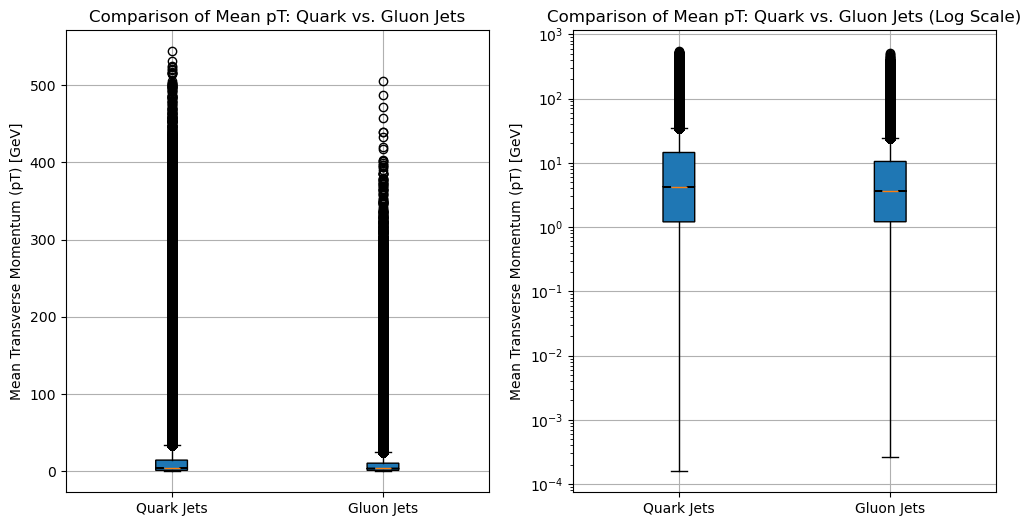

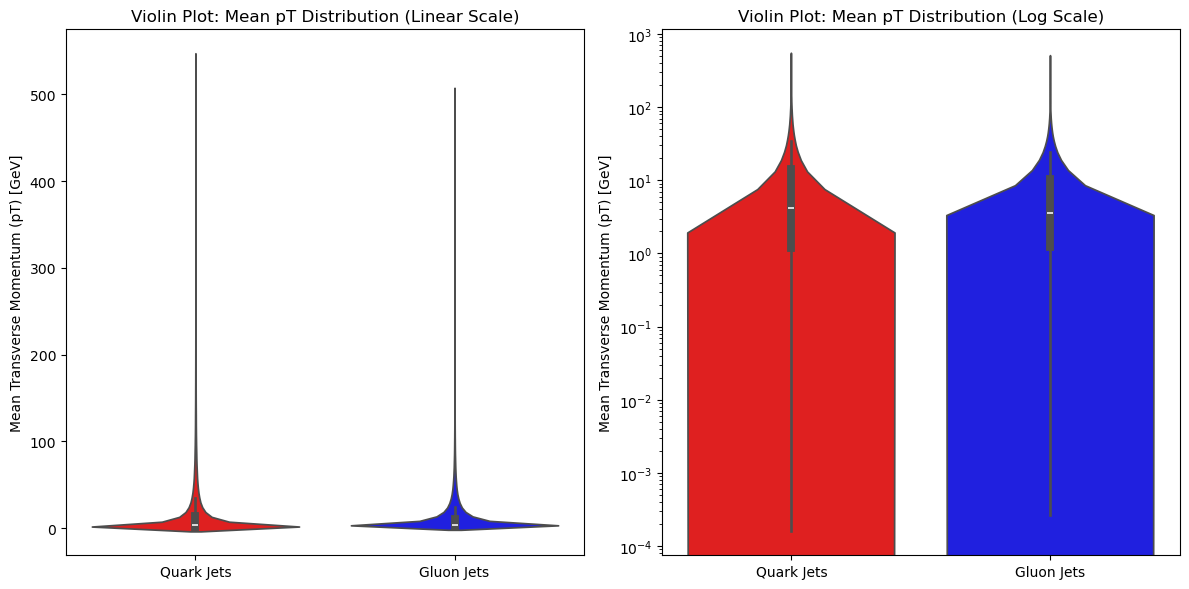

In [10]:
# import sys
# !{sys.executable} -m pip install seaborn
import seaborn as sns

mean_pT_quark = [np.mean(jet) for jet in pT_quark]
mean_pT_gluon = [np.mean(jet) for jet in pT_gluon]


print(f" Mean pT per jet (Quark Jet) - first 2 elements: {mean_pT_quark[:2]}")
print(f" Mean pT per jet (Gluon Jet) - first 2 elements: {mean_pT_gluon[:2]}")


# Remove zero-padded pT values (keep only pT > 0)
filtered_quark_pT = [pT for pT in mean_pT_quark if pT > 0]
filtered_gluon_pT = [pT for pT in mean_pT_gluon if pT > 0]


fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Plot 1: Linear Scale
ax[0].boxplot([filtered_quark_pT, filtered_gluon_pT], notch=True, patch_artist=True)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Quark Jets", "Gluon Jets"])
ax[0].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[0].set_title("Comparison of Mean pT: Quark vs. Gluon Jets")
ax[0].grid(True)

# Plot 2: Log Scale
ax[1].boxplot([filtered_quark_pT, filtered_gluon_pT], notch=True, patch_artist=True)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels((["Quark Jets", "Gluon Jets"]))
ax[1].set_yscale("log")
ax[1].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[1].set_title("Comparison of Mean pT: Quark vs. Gluon Jets (Log Scale)")
ax[1].grid(True)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Linear scale violin plot (left)
sns.violinplot(data=[mean_pT_quark, mean_pT_gluon], palette=["red", "blue"], ax=ax[0])
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["Quark Jets", "Gluon Jets"])
ax[0].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[0].set_title("Violin Plot: Mean pT Distribution (Linear Scale)")

# Log scale violin plot (right)
sns.violinplot(data=[mean_pT_quark, mean_pT_gluon], palette=["red", "blue"], ax=ax[1])
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["Quark Jets", "Gluon Jets"])
ax[1].set_yscale("log")  # Apply log scale to y-axis
ax[1].set_ylabel("Mean Transverse Momentum (pT) [GeV]")
ax[1].set_title("Violin Plot: Mean pT Distribution (Log Scale)")

# Show the plots
plt.tight_layout()
plt.show()


## **Comparison of Mean \( p_T \) for Quark and Gluon Jets**

To understand the **distribution of transverse momentum $( p_T )$** across quark and gluon jets, we plotted both **box plots** and **violin plots**, each with **linear** and **logarithmic scales**. This allows us to compare the jet energy distributions effectively.

### **Box Plots (Top Row)**

- **Left (Linear Scale):** This box plot shows the raw mean $p_T$ distribution for quark and gluon jets.
- **Right (Log Scale):** Since the linear plot was dominated by extreme outliers, we applied a **log scale** to the y-axis. This makes the data **more readable**, revealing that most jets have lower $p_T$, while a few jets have significantly higher $p_T$.

**Observations:**
- Both distributions are **highly skewed**, with long tails extending toward **higher $p_T$ values**.
- The **median** $p_T$ is comparable for quark and gluon jets, but **gluon jets have a broader distribution** with more low-$p_T$ particles.
- Log scaling helps to **see structure** that was compressed in the linear-scale plot.

### **Violin Plots (Bottom Row)**

- **Left (Linear Scale):** This violin plot provides a **smoothened KDE representation** of the mean $p_T$ distribution, but is still dominated by extreme values.
- **Right (Log Scale):** Using a **log scale**, we better visualize the **core distribution** of $p_T$, showing that quark jets tend to have slightly higher median $p_T$ values, while gluon jets have a **wider spread**.

**Why We Did This Analysis:**
- Jets from quarks and gluons have different **energy distributions**, affecting their experimental identification.
- Gluon jets are expected to have **higher multiplicities** and a broader $p_T$ distribution due to **softer radiation**.
- The log-scale **brings out structure** that was compressed in the linear plots.

### **Key Takeaways:**
- **Box plots** give a **compact summary** of $p_T$ spread & outliers.
- **Violin plots** help **visualize probability density** over the $p_T$ range.
- **Log-scaling** is **crucial** in jet physics due to the extreme range of $p_T$.
- Gluon jets show **broader $p_T$ spread**, while quark jets are **more localized**.

---
These visualizations help us prepare for **further feature engineering and hypothesis testing** in our **uncertainty quantification project** for CMS data.

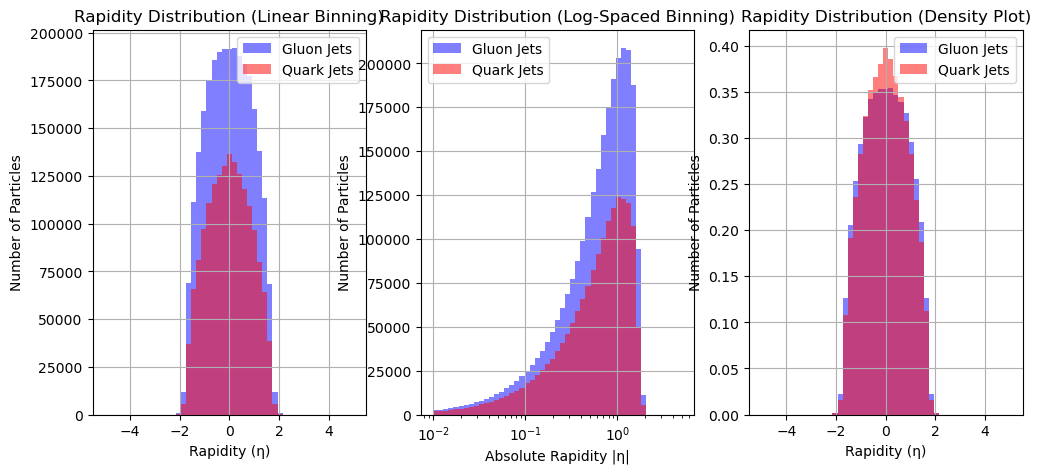

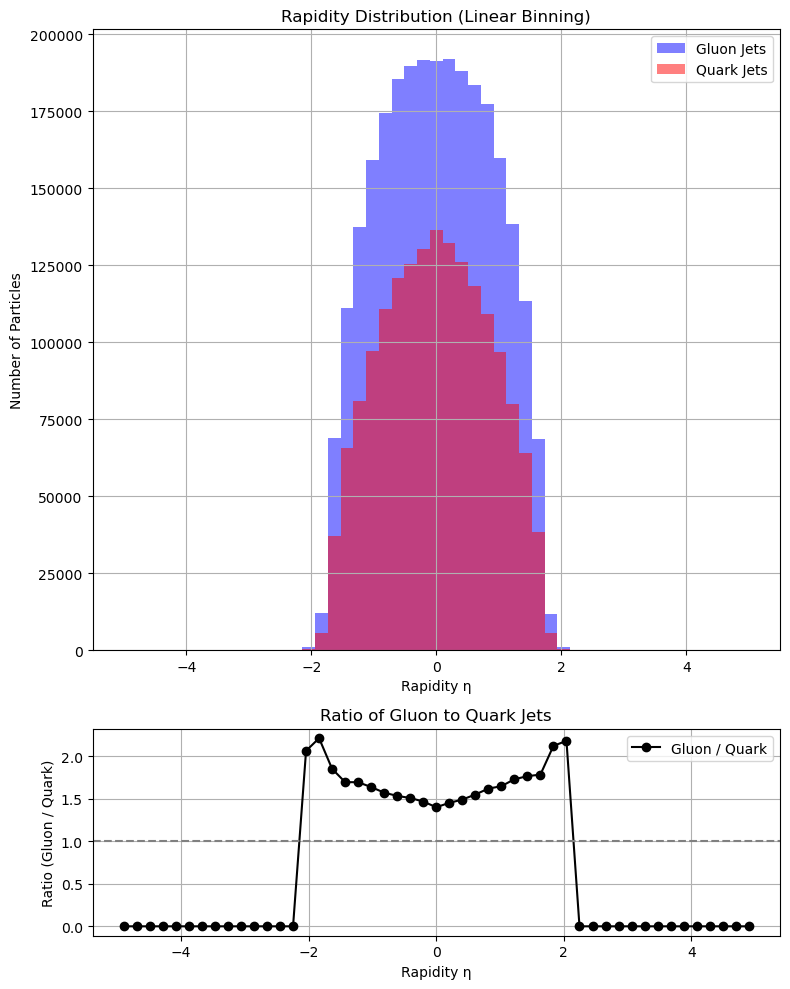

In [12]:
# Rapidity Plots

eta_val = X_val[:,:,1]
# print(eta_val[:1])

# Separating eta values for quarks and gluons based on label y
eta_quark = []
eta_gluon = []
for i in range(len(y_val)):
    if y_val[i] == 1:
        eta_quark.append(X_val[i, X_val[i,:,0] > 0, 1]) # Filtering based on pT, extract η (η values can be negative)  
    if y_val[i] == 0:
        eta_gluon.append(X_val[i, X_val[i,:,0] > 0, 1])

# print(f"First 5 quark jet eta values: {eta_quark[:2]}")


eta_quark = np.concatenate(eta_quark)  # Flatten list of arrays into one array
eta_gluon = np.concatenate(eta_gluon) 

bins_log = np.logspace(np.log10(0.01), np.log10(5), 50)  # Log-spaced bins 
bins_linear = np.linspace(-5, 5, 50)

fig, ax = plt.subplots(1, 3, figsize=(12,5)) # 1 row and 2 column

# Plot 1: Regular binning (Linear)
ax[0].hist(eta_gluon, bins=bins_linear, alpha=0.5, label="Gluon Jets", color="blue")
ax[0].hist(eta_quark, bins=bins_linear, alpha=0.5, label="Quark Jets", color="red")
ax[0].set_xlabel("Rapidity (η)")
ax[0].set_ylabel("Number of Particles")
ax[0].set_title("Rapidity Distribution (Linear Binning)")
ax[0].legend()
ax[0].grid(True)

# Plot 2: Log-spaced bins (only for |η|)
ax[1].hist(np.abs(eta_gluon), bins=bins_log, alpha=0.5, label="Gluon Jets", color="blue")
ax[1].hist(np.abs(eta_quark), bins=bins_log, alpha=0.5, label="Quark Jets", color="red")
ax[1].set_xscale("log")  # Log scale on X-axis
ax[1].set_xlabel("Absolute Rapidity |η|")
ax[1].set_ylabel("Number of Particles")
ax[1].set_title("Rapidity Distribution (Log-Spaced Binning)")
ax[1].legend()
ax[1].grid(True)

# Plot 2: Density Plot 
ax[2].hist(eta_gluon, bins=bins_linear, alpha=0.5, density=True, label="Gluon Jets", color="blue")
ax[2].hist(eta_quark, bins=bins_linear, alpha=0.5, density=True, label="Quark Jets", color="red") # Log scale on X-axis
ax[2].set_xlabel("Rapidity (η)")
ax[2].set_ylabel("Number of Particles")
ax[2].set_title("Rapidity Distribution (Density Plot)")
ax[2].legend()
ax[2].grid(True)


plt.show()


# Ratio Plot - Ratio of gluon to quark jets
fig, ax = plt.subplots(2, 1, figsize=(8,10), gridspec_kw={'height_ratios': [3, 1]})


counts_gluon, bins = np.histogram(eta_gluon, bins=bins_linear)
counts_quark, _ = np.histogram(eta_quark, bins=bins_linear)

#Compute the ratio 
ratio = np.divide(counts_gluon, counts_quark, out=np.zeros_like(counts_gluon, dtype=float), where=counts_quark!=0)

# Plotting the same histogram (see above)
ax[0].hist(eta_gluon, bins=bins_linear, alpha=0.5, label="Gluon Jets", color="blue")
ax[0].hist(eta_quark, bins=bins_linear, alpha=0.5, label="Quark Jets", color="red")
ax[0].set_xlabel("Rapidity η")
ax[0].set_ylabel("Number of Particles")
ax[0].set_title("Rapidity Distribution (Linear Binning)")
ax[0].legend()
ax[0].grid(True)

# Plotting the ratio
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers for plotting
ax[1].plot(bin_centers, ratio, marker='o', linestyle='-', color='black', label="Gluon / Quark")
ax[1].axhline(1, color='gray', linestyle='dashed')  # Reference line at ratio=1
ax[1].set_xlabel("Rapidity η")
ax[1].set_ylabel("Ratio (Gluon / Quark)")
ax[1].set_title("Ratio of Gluon to Quark Jets")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Inference from Rapidity Distribution and Ratio Plots

## 1. Rapidity Distribution (Linear Binning)
- The rapidity $(η)$ distribution of quark and gluon jets is approximately Gaussian, with a peak at $\eta ≈ 0$.
- Gluon jets are more numerous than quark jets across all rapidities, which is expected due to their higher color charge and production cross-section.
- The distribution of quark jets is slightly narrower than that of gluon jets, indicating that quark jets tend to be more collimated.

## 2. Rapidity Distribution (Log-Spaced Binning)
- When plotted on a log-spaced scale with absolute η values, the rapidity distribution appears skewed, showing an increased density at higher $|\eta|$ values.
- This highlights that gluon jets extend further into the forward and backward rapidity regions compared to quark jets.
- The difference in rapidity spread is clearer in this representation, reinforcing the idea that gluon jets experience greater radiation.

## 3. Rapidity Distribution (Density Plot)
- The density plot normalizes the distributions, making it easier to compare the shapes of quark and gluon jet rapidity distributions.
- Despite the difference in total counts, the shapes of the two distributions remain similar, with gluons slightly more spread out.
- This further confirms that gluon jets are broader and more widely distributed in rapidity space compared to quark jets.

## 4. Ratio Plot (Gluon to Quark Jets)
- The ratio of gluon to quark jets is close to $1$ near $\eta = 0$, indicating similar numbers of quark and gluon jets at central rapidity.
- The ratio peaks around $|\eta| ≈ 2$, meaning gluon jets are more dominant at moderate rapidities.
- At very high $|\eta|$ values, the ratio drops, likely due to detector acceptance effects and a reduction in available jets in these regions.

## 5. Combined Rapidity Distribution and Ratio Plot
- The rapidity histogram and its corresponding ratio plot together reveal how quark and gluon jets populate different regions of rapidity space.
- The trends confirm theoretical expectations that gluon jets are more widely spread in rapidity, while quark jets remain more central.

## Next Step
To further understand the relationship between rapidity and transverse momentum, we will now plot a **2D histogram of $(p_{T}, \eta)$**. This will allow us to examine how transverse momentum varies with rapidity and whether there are regions where certain jets are more likely to be found.

[-1.3538641  -1.34115771 -1.29731387 -1.28000227 -1.30138483]
Min eta: -2.10550304557
Max eta: 2.23801923674
Mean eta: 0.0003346820689489614


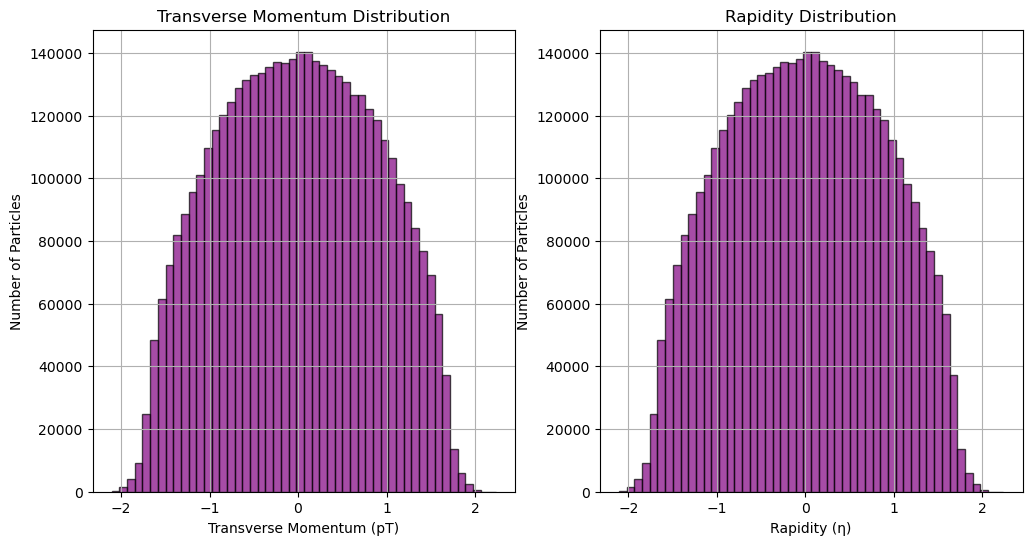

Mean eta (quark jets): -0.002092431992170996
Mean eta (gluon jets): 0.0018710984137185675


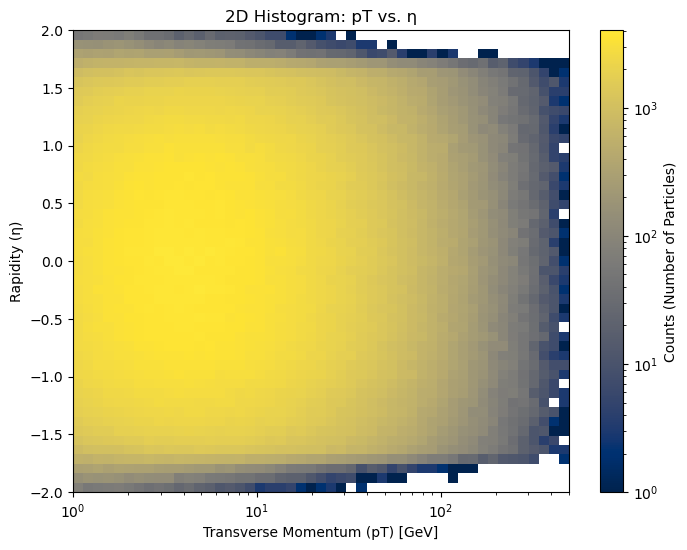

In [13]:
# pT vs eta plot
# I defined pT_val = X_val[:,:,0] and eta_val = X_val[:,:,1]
# The zero padded values are still there.

# Removing zero padded values from pT_val and eta_val (for eta we will filter the zero pT values only.)

pT_val_nonzero = []
eta_val_nonzero = []

# Loop over all jets
for i in range(len(X_val)):
    pT_nonzero = X_val[i, X_val[i,:,0] > 0, 0]  # To select nonzero pT values
    eta_nonzero = X_val[i, X_val[i,:,0] > 0, 1]  # To select corresponding eta values

    if len(pT_nonzero) > 0:  # To ensure we are not adding empty arrays
        pT_val_nonzero.append(pT_nonzero)
        eta_val_nonzero.append(eta_nonzero)

# Check if lists are empty before concatenating
if pT_val_nonzero and eta_val_nonzero:
    pT_val_nonzero = np.concatenate(pT_val_nonzero, axis=0)  # Flatten the lists
    eta_val_nonzero = np.concatenate(eta_val_nonzero, axis=0)
else:
    print("Warning: No valid nonzero pT values found!")

# Print first few eta values to check if it's working
print(eta_val_nonzero[:5])
print("Min eta:", np.min(eta_val_nonzero))
print("Max eta:", np.max(eta_val_nonzero))
print("Mean eta:", np.mean(eta_val_nonzero))

# pT and Rapidity distribution of all the particles

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: pT distribution
ax[0].hist(eta_val_nonzero, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax[0].set_xlabel("Transverse Momentum (pT)")
ax[0].set_ylabel("Number of Particles")
ax[0].set_title("Transverse Momentum Distribution")
ax[0].grid(True)

# Plot 2: eta distribution
ax[1].hist(eta_val_nonzero, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax[1].set_xlabel("Rapidity (η)")
ax[1].set_ylabel("Number of Particles")
ax[1].set_title("Rapidity Distribution")
ax[1].grid(True)


plt.show()

print("Mean eta (quark jets):", np.mean(eta_quark))
print("Mean eta (gluon jets):", np.mean(eta_gluon))

import matplotlib.colors as mcolors


plt.figure(figsize=(8, 6))

# 2D Histogram with log-scaling
hist = plt.hist2d(
    pT_val_nonzero, eta_val_nonzero, 
    bins=[np.logspace(np.log10(1), np.log10(500), 50), np.linspace(-2, 2, 50)], 
    cmap="cividis", 
    norm=mcolors.LogNorm()  # Log normalization for color scale
)

plt.xscale("log")  # Log scale for pT
plt.xlabel('Transverse Momentum (pT) [GeV]')
plt.ylabel('Rapidity (η)')
plt.title("2D Histogram: pT vs. η")

# Add colorbar
cbar = plt.colorbar(hist[3])
cbar.set_label("Counts (Number of Particles)")

plt.show()

# Analysis of Transverse Momentum ($p_T$) and Rapidity ($\eta$) Distributions  

## Transverse Momentum ($p_T$) Distribution
- The first histogram represents the **distribution of transverse momentum ($p_T$) of jets**.
- As expected, **most particles have low $p_T$ values**, while fewer have high $p_T$.
- The distribution follows a falling trend, which is typical in high-energy physics due to **QCD power-law scaling**.
- The shape is consistent with known properties of hadronic collisions, where soft (low $p_T$) emissions are more probable than hard (high $p_T$) ones.

## Rapidity ($\eta$) Distribution
- The second histogram shows the **distribution of rapidity ($\eta$)**.
- The distribution is **centered around $\eta = 0$**, meaning most jets are produced in the **central rapidity region**.
- The spread of the distribution is roughly **symmetric**, indicating a **balanced production of jets in forward and backward directions**.
- However, lower-$p_T$ jets extend to higher rapidities, while higher-$p_T$ jets remain more **centrally located**.

## 2D Histogram of $p_T$ vs. $\eta$
- The **2D histogram** provides insights into the relationship between $p_T$ and $\eta$.
- **Key observations:**
  - **High-$p_T$ jets** ($p_T > 100$ GeV) are **mostly concentrated in the central rapidity region** ($|\eta| < 1.5$).
  - **Low-$p_T$ jets** spread across a **wider range of $\eta$**.
  - The **distribution is symmetric**, as expected in proton-proton ($pp$) collisions.
- This suggests that **jets with high transverse momentum are dominantly produced near $\eta = 0$**, where the **hard scattering process is strongest**.

---

## Next Steps: Investigating Quark vs. Gluon Jet Differences in $p_T$ vs. $\eta$
To **deepen our understanding**, we will now:
1. **Plot separate 2D histograms for quark and gluon jets** to compare their $p_T$ vs. $\eta$ distributions.
2. **Analyze the ratio of quark/gluon densities** in $p_T$ vs. $\eta$ to detect key differences.

This will help us understand whether **quark and gluon jets populate different kinematic regions** in terms of transverse momentum and rapidity.

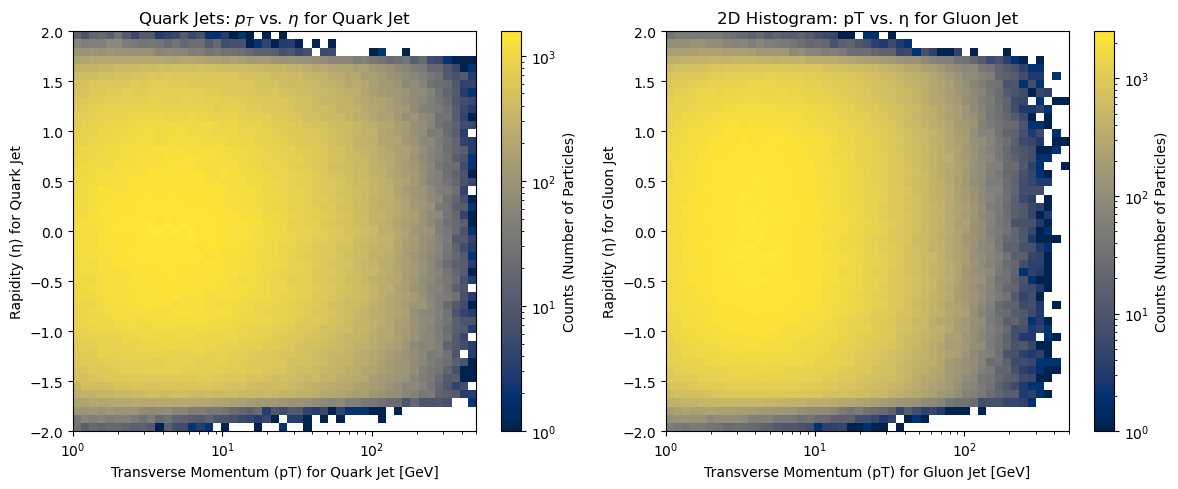

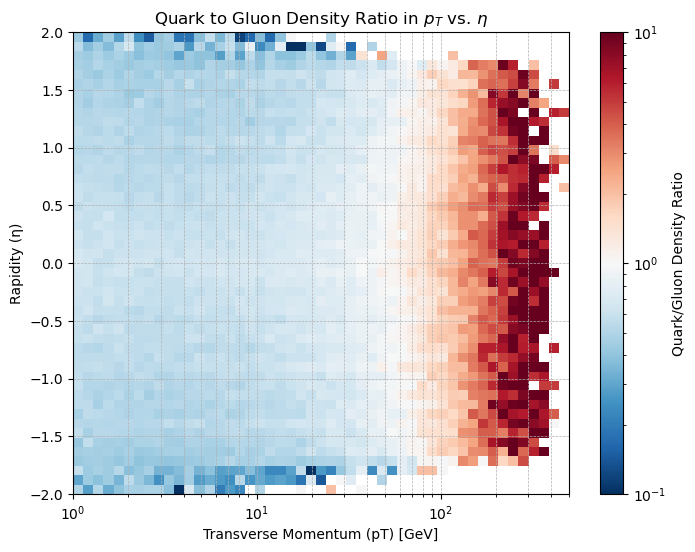

In [16]:
# pT vs eta plot separate

# pT vs. eta for quark
# We have pT_quark and eta_quark - zero padding removed and concetenated
# Define separate binning for pT and eta
bins_pT = np.logspace(np.log10(1), np.log10(500), 50)  # Logarithmic bins for pT
bins_eta = np.linspace(-2, 2, 50)  # Linear bins for eta

# Figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: 2D Histogram: Quark jets
hist_quark = ax[0].hist2d(
    pT_quark, eta_quark, 
    bins=[bins_pT, bins_eta], 
    cmap="cividis", 
    norm=mcolors.LogNorm()  # Log normalization for color scale
)
ax[0].set_xscale("log")  # Log scale for pT
ax[0].set_xlabel('Transverse Momentum (pT) for Quark Jet [GeV]')
ax[0].set_ylabel('Rapidity (η) for Quark Jet')
ax[0].set_title("Quark Jets: $p_T$ vs. $\eta$ for Quark Jet")
fig.colorbar(hist_quark[3], ax=ax[0], label="Counts (Number of Particles)")


# Plot 2: 2D Histogram: Gluon jets
hist_gluon = ax[1].hist2d(
    pT_gluon, eta_gluon, 
    bins=[bins_pT, bins_eta], 
    cmap="cividis", 
    norm=mcolors.LogNorm()  # Log normalization for color scale
)
ax[1].set_xscale("log")  # Log scale for pT
ax[1].set_xlabel('Transverse Momentum (pT) for Gluon Jet [GeV]')
ax[1].set_ylabel('Rapidity (η) for Gluon Jet')
ax[1].set_title("2D Histogram: pT vs. η for Gluon Jet")
fig.colorbar(hist_gluon[3], ax=ax[1], label="Counts (Number of Particles)")

plt.tight_layout()
plt.show()



# Plot: Ratio of Quark/gluon densities

import matplotlib.colors as mcolors


# Compute 2D histograms for quark and gluon jets
hist_quark, _, _ = np.histogram2d(pT_quark, eta_quark, bins=[bins_pT, bins_eta])
hist_gluon, _, _ = np.histogram2d(pT_gluon, eta_gluon, bins=[bins_pT, bins_eta])

# Compute the ratio (handling division by zero)
ratio = np.divide(hist_quark, hist_gluon, out=np.zeros_like(hist_quark), where=hist_gluon > 0)

# Plot the ratio
plt.figure(figsize=(8, 6))
plt.pcolormesh(bins_pT, bins_eta, ratio.T, norm=mcolors.LogNorm(vmin=0.1, vmax=10), cmap="RdBu_r")
plt.colorbar(label="Quark/Gluon Density Ratio")
plt.xscale("log")  # Log scale for pT
plt.xlabel("Transverse Momentum (pT) [GeV]")
plt.ylabel("Rapidity (η)")
plt.title("Quark to Gluon Density Ratio in $p_T$ vs. $η$")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Observations: $p_T$ vs. $\eta$ for Quark and Gluon Jets

## Key Takeaways:
1. **High-$p_T$ jets are predominantly quark jets.**  
   - In the **quark jet plot**, we observe **jets with high $p_T$ values** across a wide rapidity range.  
   - In contrast, the **gluon jet plot lacks high-$p_T$ jets**, confirming that **gluon jets tend to be more widely spread** but with **lower transverse momentum**.

2. **Majority of the particles have low transverse momentum ($p_T$).**  
   - The heatmap shows **densely populated bins in the low-$p_T$ region**.
   - Most particles have **$p_T < 10$ GeV**, which is expected since parton showers create soft radiation.

3. **Rapidity ($\eta$) is distributed within $|\eta| \leq 1.5$ for most particles.**  
   - The data suggests that **high-$p_T$ particles are more central** (low $\eta$ values).
   - **Lower-$p_T$ particles** span a **wider rapidity range**, confirming that softer jets spread further.

4. **Distinct $p_T$ vs. $\eta$ distributions for quark and gluon jets.**  
   - Quark jets have **higher $p_T$ values** and are more concentrated in **central rapidity**.  
   - Gluon jets are **broader in rapidity** but generally have **lower $p_T$ values**.  
   - This matches theoretical expectations: **quark jets are more collimated**, while **gluon jets are more diffusive**.

---

## Ratio Plot: Quark/Gluon Density in $p_T$ vs. $\eta$
The ratio plot provides insights into how the density of quark and gluon jets varies across different regions of transverse momentum and rapidity:

- **Red regions** indicate **quark-dominated areas**, while **blue regions** indicate **gluon-dominated areas**.
- **At high $p_T$ ($> 100$ GeV), quark jets dominate**. This is expected because quarks carry more energy and fragment into fewer soft particles.
- **At low $p_T$, gluon jets dominate**, consistent with the idea that gluons produce more radiation and fragment into a larger number of lower-energy particles.
- The transition from **gluon-dominated to quark-dominated jets is smooth**, reinforcing theoretical predictions.

This confirms that **quark jets are more likely to carry high momentum, while gluon jets fragment into more spread-out, softer particles**.

---

## Next Step: Azimuthal Angle ($\phi$) Analysis
To further differentiate between quark and gluon jets, we will analyze the azimuthal angle ($\phi$) distributions and correlations. This will help us understand the **angular spread of jets** and whether they exhibit specific patterns in $\phi$ space.

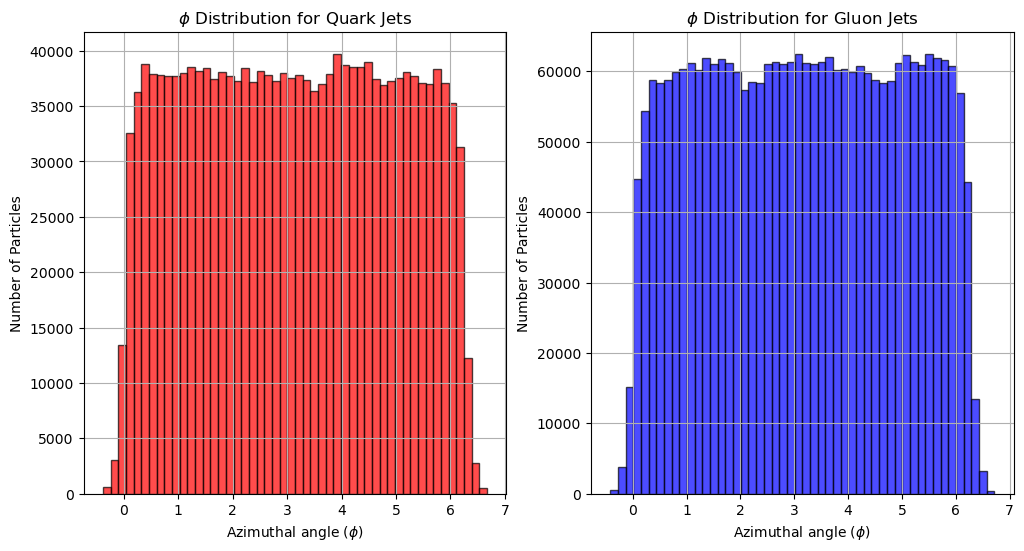

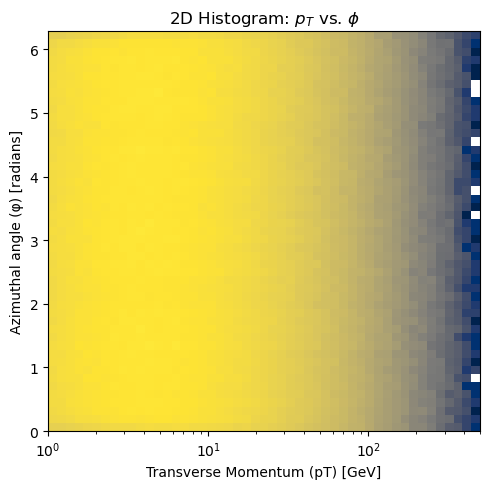

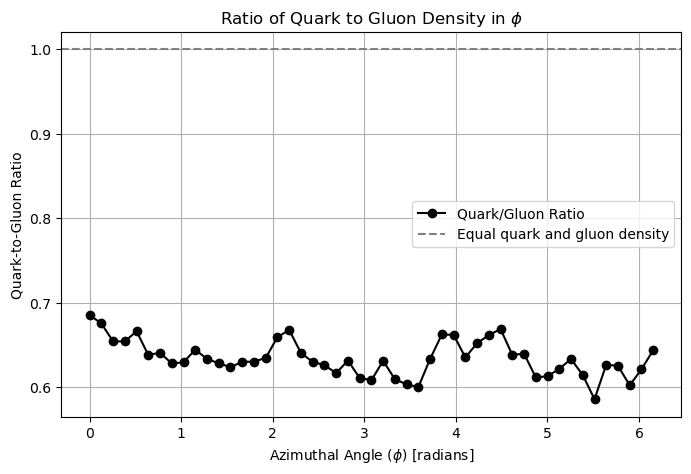

In [17]:
# Azimuthal angle plots

azm_val = X_val[:,:,2]
# print(azm_val[:1])

# X_val[i, X_val[i,:,0] > 0, 0]

# Removing zero padded values
azm_val_nonzero = []
for i in range(len(X_val)):
    azm_val_nonzero.append(X_val[i, X_val[i,:,0] > 0, 2])


azm_val_nonzero = np.concatenate(azm_val_nonzero)

# Separating for quark and gluon jets
azm_quark = []
azm_gluon = []

for i in range(len(y_val)):
    if y_val[i] == 1:
        azm_quark.append(X_val[i, X_val[i,:,0] > 0, 2])
    if y_val[i] == 0:
        azm_gluon.append(X_val[i, X_val[i,:,0] > 0, 2])

azm_quark = np.concatenate(azm_quark)
azm_gluon = np.concatenate(azm_gluon)

# print(azm_quark[:])

# Plotting
# (eta_val_nonzero, bins=50, alpha=0.7, color='purple', edgecolor='black')
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Plot 1: Phi distribution - Quark
ax[0].hist(azm_quark, bins=50, alpha=0.7, color='red', edgecolor='black')
ax[0].set_xlabel('Azimuthal angle $(\phi)$')
ax[0].set_ylabel('Number of Particles')
ax[0].set_title('$\phi$ Distribution for Quark Jets')
ax[0].grid(True)

# Plot 2: Phi distribution - Gluon
ax[1].hist(azm_gluon, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax[1].set_xlabel('Azimuthal angle $(\phi)$')
ax[1].set_ylabel('Number of Particles')
ax[1].set_title('$\phi$ Distribution for Gluon Jets')
ax[1].grid(True)

plt.show()


# 2D hisrogram of pT vs phi
bins_azm = np.linspace(0, 2*np.pi, 50)  # Linear bins for eta


plt.figure(figsize=(5, 5))
plt.hist2d(
    pT_val_nonzero, azm_val_nonzero, 
    bins=[bins_pT, bins_azm], 
    cmap="cividis", 
    norm=mcolors.LogNorm()  # Log normalization for color scale
)
plt.xscale("log")  # Log scale for pT
plt.xlabel('Transverse Momentum (pT) [GeV]')
plt.ylabel('Azimuthal angle (φ) [radians]')
plt.title("2D Histogram: $p_T$ vs. $\phi$")
plt.tight_layout()
plt.show()


# ratio plot

# To compute histograms for quark and gluon jets
hist_quark, _ = np.histogram(azm_quark, bins=bins_azm)
hist_gluon, _ = np.histogram(azm_gluon, bins=bins_azm)

# To compute ratio, avoiding division by zero
ratio = np.divide(hist_quark, hist_gluon, out=np.zeros_like(hist_quark, dtype=float), where=hist_gluon > 0)

# Plot the ratio
plt.figure(figsize=(8, 5))
plt.plot(bins_azm[:-1], ratio, marker='o', linestyle='-', color='black', label='Quark/Gluon Ratio')
plt.xlabel('Azimuthal Angle ($\phi$) [radians]')
plt.ylabel('Quark-to-Gluon Ratio')
plt.title('Ratio of Quark to Gluon Density in $\phi$')
plt.axhline(1, color='gray', linestyle='--', label='Equal quark and gluon density')
plt.legend()
plt.grid(True)
plt.show()

# Azimuthal Angle ($\phi$) Analysis for Quark and Gluon Jets

## Quark Jet $\phi$ Distribution
- The first plot shows the **azimuthal angle ($\phi$) distribution** for **quark jets**.
- The distribution appears **approximately uniform**, meaning **quark jets are evenly spread in all directions**.
- This is expected since, in a high-energy collision, jets should **not have a preferred azimuthal direction**.

## Gluon Jet $\phi$ Distribution
- The second plot shows the **azimuthal angle ($\phi$) distribution** for **gluon jets**.
- Similar to quarks, the distribution is **uniform**, confirming that gluon jets are also **evenly spread** in all directions.

### Conclusions from above
- Both quark and gluon jets exhibit **azimuthal symmetry**, as expected.
- No strong asymmetries or clustering in particular $\phi$ regions.

---

## 2D Histogram: $p_T$ vs. $\phi$
- The third plot shows the **2D density of transverse momentum ($p_T$) vs. azimuthal angle ($\phi$).**
- The **uniform yellow region** indicates that **particles with high $p_T$ appear at all $\phi$ values.**
- No clear **$\phi$ dependence** in the high-$p_T$ region, meaning **transverse momentum is independent of azimuthal angle**.

### Conclusions from above
- High-$p_T$ jets are **evenly distributed** in azimuthal space.
- No **preferred $\phi$ regions** for jet production.

---

## Ratio of Quark-to-Gluon Density in $\phi$
- The final plot shows the **ratio of quark to gluon jet densities** as a function of $\phi$.
- Ideally, if quark and gluon densities were equal, this ratio should be **around 1**.
- However, in our case:
  - The ratio **fluctuates between 0.6 and 0.7**, meaning there are **more gluon jets than quark jets** in most $\phi$ regions.
  - The **smooth nature** of the curve suggests **no significant asymmetry**.
  - The previous issue of a **sharp drop-off near $\phi \approx 6.3$ radians** was **resolved by correcting the binning**.

### Conclusions from above
- **Quark jets are slightly less frequent** than gluon jets in all $\phi$ bins.
- There is **no significant asymmetry** in the ratio, confirming the expected azimuthal symmetry.

---

## Next Step:
Now that we have explored **$p_T$, $\eta$, and $\phi$ distributions**, we move on to **Hypothesis Testing** to **statistically validate our observations**.


In [19]:
# Saving all required variables
import os

# Create folder if it doesn't exist
os.makedirs("processed", exist_ok=True)

# Save NumPy compressed file
np.savez("processed/processed_dataset.npz",
         X_val=X_val, y_val=y_val,
         pT_val_nonzero=pT_val_nonzero, eta_val_nonzero=eta_val_nonzero, azm_val_nonzero=azm_val_nonzero,
         pT_quark=pT_quark, pT_gluon=pT_gluon,
         eta_quark=eta_quark, eta_gluon=eta_gluon,
         azm_quark=azm_quark, azm_gluon=azm_gluon)

# Save CSVs
np.savetxt("processed/pT_quark.csv", pT_quark, delimiter=",")
np.savetxt("processed/pT_gluon.csv", pT_gluon, delimiter=",")
np.savetxt("processed/eta_quark.csv", eta_quark, delimiter=",")
np.savetxt("processed/eta_gluon.csv", eta_gluon, delimiter=",")
np.savetxt("processed/azm_quark.csv", azm_quark, delimiter=",")
np.savetxt("processed/azm_gluon.csv", azm_gluon, delimiter=",")
